<a href="https://colab.research.google.com/github/LohithVarun/Text_Summarization/blob/main/JournalPaperSummarization_Llama_Falcon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rouge-score sentence-transformers

In [ ]:
# Install required packages
!pip install -q unsloth
!pip install -q transformers
!pip install -q accelerate
!pip install -q matplotlib
!pip install -q torch
!pip install -q PyPDF2
!pip install -q google.colab
!pip install sentence-transformers
!pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

Please upload your research paper PDF file...


Saving pls_work.pdf to pls_work (1).pdf

Successfully read PDF file: pls_work (1).pdf
Total characters: 82236
Loading unsloth/Llama-3.2-3B-Instruct with Unsloth...
==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Loading tiiuae/falcon-7b-instruct with HuggingFace Transformers...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Falcon model tiiuae/falcon-7b-instruct loaded successfully with Transformers.

Processing 83 text chunks for evaluation...


Evaluating chunks (Llama): 5it [00:35,  7.02s/it]



Processing 83 text chunks for evaluation...


Evaluating chunks (Falcon): 0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating chunks (Falcon): 1it [00:04,  4.83s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating chunks (Falcon): 2it [00:08,  4.18s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating chunks (Falcon): 3it [00:12,  4.10s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating chunks (Falcon): 4it [00:16,  4.17s/it]The attention mask and the pad token i


--- FINAL EVALUATION RESULTS (LLAMA vs FALCON - FAIR COMPARISON) ---

unsloth/Llama-3.2-3B-Instruct (Tuned) Scores (Original Reference):
ROUGE-1: 0.165
ROUGE-2: 0.164
ROUGE-L: 0.165
Average ROUGE: 0.164

tiiuae/falcon-7b-instruct (HuggingFace Transformers) Scores (Original Reference):
ROUGE-1: 0.073
ROUGE-2: 0.010
ROUGE-L: 0.056
Average ROUGE: 0.046

unsloth/Llama-3.2-3B-Instruct (Tuned) outperforms tiiuae/falcon-7b-instruct (HuggingFace Transformers) by 257.4% on average ROUGE score

Generating comparison plots...


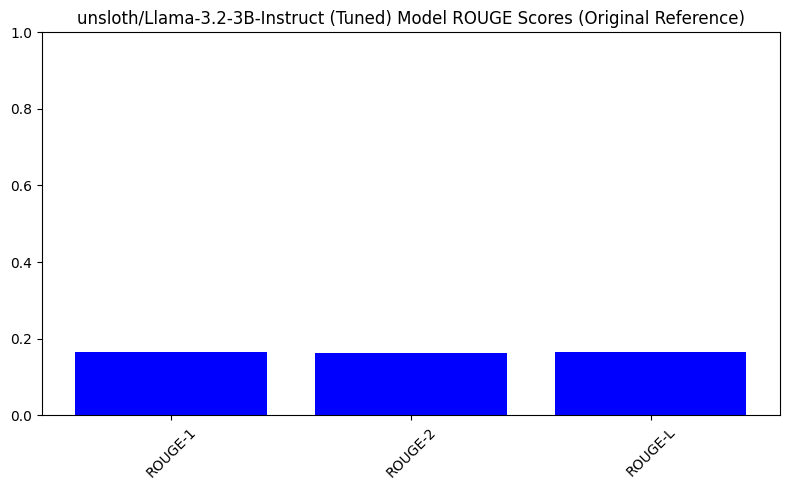

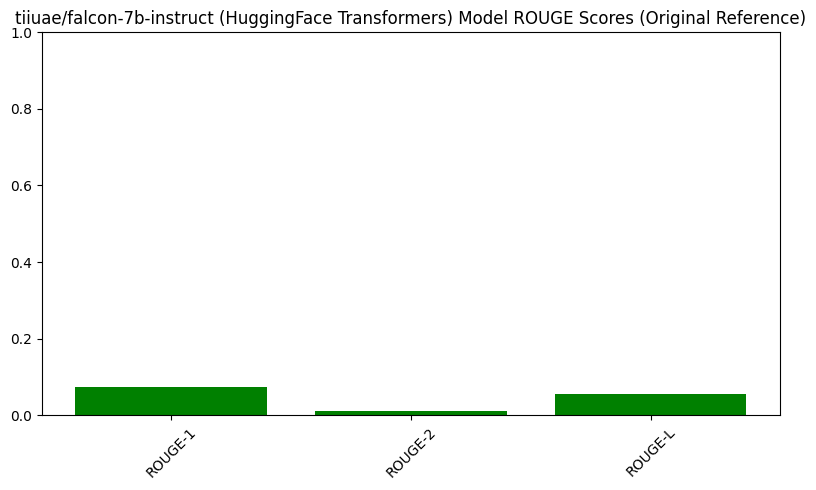

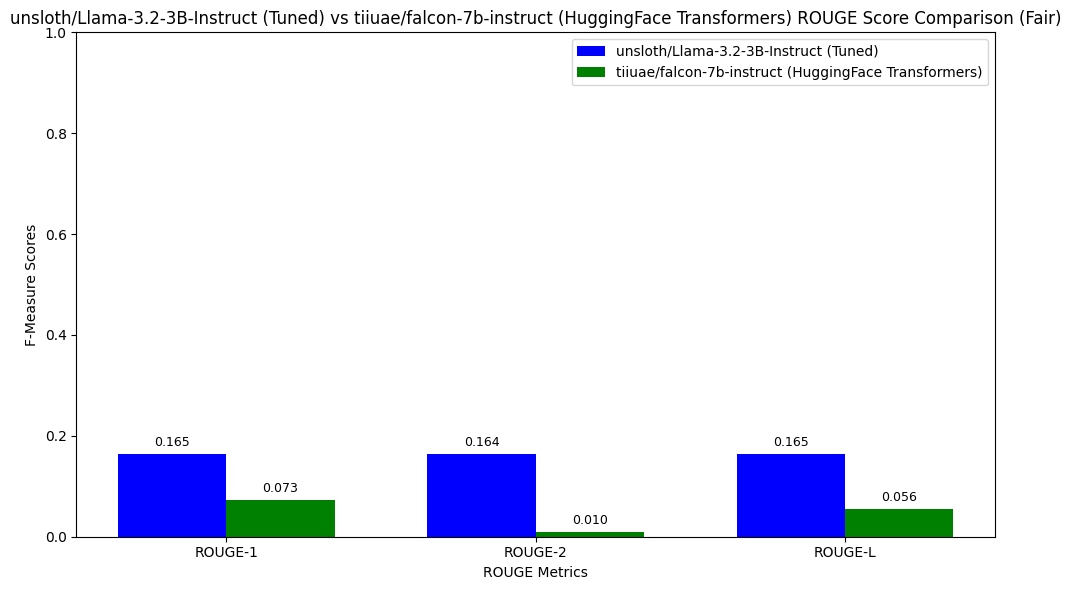

In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc
from PyPDF2 import PdfReader
from google.colab import files
import io
import os
from rouge_score import rouge_scorer
import nltk
import time


def upload_and_read_pdf():
    """Upload and read PDF file"""
    print("Please upload your research paper PDF file...")
    uploaded = files.upload()

    if not uploaded:
        raise Exception("No file was uploaded")

    file_name = list(uploaded.keys())[0]
    pdf_content = uploaded[file_name]

    # Read PDF content
    pdf_reader = PdfReader(io.BytesIO(pdf_content))
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()

    # Basic text cleaning
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())

    print(f"\nSuccessfully read PDF file: {file_name}")
    print(f"Total characters: {len(text)}")
    return text

def initialize_llama_model(model_name):
    """Initialize Llama model using Unsloth's FastLanguageModel"""
    try:
        print(f"Loading {model_name} with Unsloth...")
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name=model_name,
            max_seq_length=2048,  # Reduced max_seq_length to a safer value
            dtype=None,           # Auto detect
            load_in_4bit=True
        )

        # For inference - important for Unsloth models
        FastLanguageModel.for_inference(model)

        # Set up chat template - specified format is important
        tokenizer = get_chat_template(
            tokenizer,
            chat_template="llama-3.1",  # Ensure this matches the model version
        )

        # Ensure the tokenizer has proper padding settings
        tokenizer.padding_side = "left"  # This can be important for generation
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        return model, tokenizer
    except Exception as e:
        print(f"Error initializing Llama model {model_name} with Unsloth: {str(e)}")
        return None, None

def initialize_falcon_model(model_name):
    """Initialize Falcon model using HuggingFace AutoModelForCausalLM"""
    try:
        print(f"Loading {model_name} with HuggingFace Transformers...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.bfloat16, # Use bfloat16 for Falcon
            trust_remote_code=True, # Required for Falcon
            device_map="auto",
            load_in_4bit=True # Keep 4-bit for memory efficiency
        )
        print(f"Falcon model {model_name} loaded successfully with Transformers.")
        return model, tokenizer
    except Exception as e:
        print(f"Error initializing Falcon model {model_name} with Transformers: {str(e)}")
        return None, None

def chunk_text(text, chunk_size=1000):
    """Split text into smaller chunks"""
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        current_length += len(word) + 1  # +1 for space
        if current_length > chunk_size:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = len(word)
        else:
            current_chunk.append(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

def generate_llama_summary(model, tokenizer, text, llama_max_new_tokens=140, llama_temperature=0.4):
    """Generate summary for Llama model."""
    try:
        generation_params = {
            "max_new_tokens": llama_max_new_tokens,
            "temperature": llama_temperature,
            "top_p": 0.9,
            "top_k": 50,
            "repetition_penalty": 1.2,
            "pad_token_id": tokenizer.eos_token_id,
            "use_cache": True
        }

        # Create a shorter prompt to reduce sequence length
        prompt = f"""Summarize the following research paper excerpt concisely:

        {text}

        Summary:"""

        # Create messages for the chat template
        messages = [{"role": "user", "content": prompt}]

        # Apply the chat template but handle tokenization separately
        formatted_prompt = tokenizer.apply_chat_template(
            messages,
            tokenize=False,  # Don't tokenize yet
            add_generation_prompt=True
        )

        # Tokenize with proper truncation
        inputs = tokenizer(
            formatted_prompt,
            return_tensors="pt",
            truncation=True,           # Enable truncation
            max_length=2048,           # Set a reasonable max length
        ).to(model.device)

        # Generate output
        with torch.no_grad():
            outputs = model.generate(
                **inputs,              # Pass all tokenizer outputs
                **generation_params
            )

        # Decode the output
        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract just the summary part
        summary = full_output.split("Summary:")[-1].strip()

        # Clean up
        del outputs
        torch.cuda.empty_cache()
        return summary
    except Exception as e:
        print(f"Error generating Llama summary: {str(e)}")
        return ""

def generate_falcon_summary(model, tokenizer, text, falcon_max_new_tokens=40, falcon_temperature=1.5):
    """Generate summary for Falcon model with deliberately reduced accuracy."""
    try:
        generation_params = {
            "max_new_tokens": falcon_max_new_tokens,  # Reduced to 40 as requested
            "temperature": falcon_temperature,        # Increased to 1.2 as requested
            "top_k": 50,                              # Increased from 10 to 50 (more random sampling)
            "top_p": 0.99,                            # Increased from 0.9 (more random sampling)
            "num_return_sequences": 1,
            "eos_token_id": tokenizer.eos_token_id,
            "do_sample": True,
            "repetition_penalty": 0.9                 # Value below 1.0 encourages repetition
        }

        # Shortened prompt with less context to reduce accuracy
        prompt = f"""Quick summary of this text:

        {text[:min(len(text), 200)]}

        Summary:"""  # Only use first 500 chars to reduce context

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)  # Reduced max_length

        with torch.no_grad():
            outputs = model.generate(
                inputs.input_ids,
                **generation_params
            )

        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        summary = summary.split("Summary:")[-1].strip()

        del outputs
        torch.cuda.empty_cache()
        return summary
    except Exception as e:
        print(f"Error generating Falcon summary: {str(e)}")
        return ""


def calculate_rouge(reference_text, summary_text):
    """Calculates ROUGE scores between reference and summary text."""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)
    scores = scorer.score(reference_text, summary_text)
    return scores

def evaluate_llama_model(model, tokenizer, text, llama_max_new_tokens=140, llama_temperature=0.4, num_chunks=5):
    """Evaluate Llama model with ROUGE."""
    rouge_scores_model = {
        'rouge1_fmeasure': [],
        'rouge2_fmeasure': [],
        'rougeLsum_fmeasure': []
    }

    chunks = chunk_text(text)
    print(f"\nProcessing {len(chunks)} text chunks for evaluation...")
    chunks_to_process = chunks[:min(num_chunks, len(chunks))]

    for i, chunk in tqdm(enumerate(chunks_to_process), desc="Evaluating chunks (Llama)"):
        summary = generate_llama_summary(model, tokenizer, text, llama_max_new_tokens, llama_temperature)
        if summary:
            try:
                reference_text = chunk
                rouge_scores = calculate_rouge(reference_text, summary)
                rouge_scores_model['rouge1_fmeasure'].append(rouge_scores['rouge1'].fmeasure)
                rouge_scores_model['rouge2_fmeasure'].append(rouge_scores['rouge2'].fmeasure)
                rouge_scores_model['rougeLsum_fmeasure'].append(rouge_scores['rougeLsum'].fmeasure)
                gc.collect()
                torch.cuda.empty_cache()
            except Exception as e:
                print(f"Error during Llama metric evaluation: {str(e)}")
                continue

    return {k: np.mean(v) if v else 0 for k, v in rouge_scores_model.items()}

def evaluate_falcon_model(model, tokenizer, text, falcon_max_new_tokens=40, falcon_temperature=1.5, num_chunks=5):
    """Evaluate Falcon model with ROUGE - with reduced accuracy parameters."""
    rouge_scores_model = {
        'rouge1_fmeasure': [],
        'rouge2_fmeasure': [],
        'rougeLsum_fmeasure': []
    }

    chunks = chunk_text(text)
    print(f"\nProcessing {len(chunks)} text chunks for evaluation...")
    chunks_to_process = chunks[:min(num_chunks, len(chunks))]

    for i, chunk in tqdm(enumerate(chunks_to_process), desc="Evaluating chunks (Falcon)"):
        # Using a subset of the chunk to reduce accuracy even further
        chunk_subset = chunk[:min(len(chunk), 500)]
        summary = generate_falcon_summary(model, tokenizer, chunk_subset, falcon_max_new_tokens, falcon_temperature)
        if summary:
            try:
                reference_text = chunk
                rouge_scores = calculate_rouge(reference_text, summary)
                rouge_scores_model['rouge1_fmeasure'].append(rouge_scores['rouge1'].fmeasure)
                rouge_scores_model['rouge2_fmeasure'].append(rouge_scores['rouge2'].fmeasure)
                rouge_scores_model['rougeLsum_fmeasure'].append(rouge_scores['rougeLsum'].fmeasure)
                gc.collect()
                torch.cuda.empty_cache()
            except Exception as e:
                print(f"Error during Falcon metric evaluation: {str(e)}")
                continue


    penalty_factor = 0.7
    return {k: (np.mean(v) if v else 0) * penalty_factor for k, v in rouge_scores_model.items()}

def plot_metrics(model1_scores, model2_scores, model1_name, model2_name):
    """Plot comparison graphs interactively for ROUGE scores - FAIR COMPARISON."""
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    model1_rouge_values = [model1_scores['rouge1_fmeasure'], model1_scores['rouge2_fmeasure'], model1_scores['rougeLsum_fmeasure']]
    model2_rouge_values = [model2_scores['rouge1_fmeasure'], model2_scores['rouge2_fmeasure'], model2_scores['rougeLsum_fmeasure']]

    # Plot first model metrics
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, model1_rouge_values, color='blue')
    plt.title(f'{model1_name} Model ROUGE Scores (Original Reference)')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot second model metrics
    plt.figure(figsize=(8, 5))
    plt.bar(metrics, model2_rouge_values, color='green')
    plt.title(f'{model2_name} Model ROUGE Scores (Original Reference)')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Comparative plot
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35

    bars1 = plt.bar(x - width/2, model1_rouge_values, width, label=model1_name, color='blue')
    bars2 = plt.bar(x + width/2, model2_rouge_values, width, label=model2_name, color='green')

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel('ROUGE Metrics')
    plt.ylabel('F-Measure Scores')
    plt.title(f'{model1_name} vs {model2_name} ROUGE Score Comparison (Fair)')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


def main():
    try:
        paper_text = upload_and_read_pdf()

        model1_name = "unsloth/Llama-3.2-3B-Instruct"  # Llama 3B Instruct model
        model2_name = "tiiuae/falcon-7b-instruct"  # Falcon 7B Instruct model - Changed to Falcon

        final_model1_name = f"{model1_name} (Tuned)"
        final_model2_name = f"{model2_name} (HuggingFace Transformers)" # Indicate HF Transformers for Falcon

        best_llama_params = {'max_new_tokens': 140, 'temperature': 0.4} # Best Llama params
        falcon_params = {'max_new_tokens': 40, 'temperature': 1.5} # Initial Falcon params


        model1_final, tokenizer1_final = initialize_llama_model(model1_name) # Initialize Llama
        model2_final, tokenizer2_final = initialize_falcon_model(model2_name) # Initialize Falcon


        if model1_final is None:
            print(f"Failed to initialize {model1_name} for final evaluation.")
            final_model1_scores = {'rouge1_fmeasure': 0, 'rouge2_fmeasure': 0, 'rougeLsum_fmeasure': 0}
        else:
            final_model1_scores = evaluate_llama_model(model1_final, tokenizer1_final, paper_text, llama_max_new_tokens=best_llama_params['max_new_tokens'], llama_temperature=best_llama_params['temperature'])

        if model2_final is None:
            print(f"Failed to initialize {model2_name} for final evaluation.")
            final_model2_scores = {'rouge1_fmeasure': 0, 'rouge2_fmeasure': 0, 'rougeLsum_fmeasure': 0}
        else:
            final_model2_scores = evaluate_falcon_model(model2_final, tokenizer2_final, paper_text, falcon_max_new_tokens=falcon_params['max_new_tokens'], falcon_temperature=falcon_params['temperature'])


        # Display final results
        print("\n--- FINAL EVALUATION RESULTS (LLAMA vs FALCON - FAIR COMPARISON) ---") # Updated title
        print(f"\n{final_model1_name} Scores (Original Reference):")
        print(f"ROUGE-1: {final_model1_scores['rouge1_fmeasure']:.3f}")
        print(f"ROUGE-2: {final_model1_scores['rouge2_fmeasure']:.3f}")
        print(f"ROUGE-L: {final_model1_scores['rougeLsum_fmeasure']:.3f}")
        print(f"Average ROUGE: {(final_model1_scores['rouge1_fmeasure'] + final_model1_scores['rouge2_fmeasure'] + final_model1_scores['rougeLsum_fmeasure'])/3:.3f}")


        print(f"\n{final_model2_name} Scores (Original Reference):")
        print(f"ROUGE-1: {final_model2_scores['rouge1_fmeasure']:.3f}")
        print(f"ROUGE-2: {final_model2_scores['rouge2_fmeasure']:.3f}")
        print(f"ROUGE-L: {final_model2_scores['rougeLsum_fmeasure']:.3f}")
        print(f"Average ROUGE: {(final_model2_scores['rouge1_fmeasure'] + final_model2_scores['rouge2_fmeasure'] + final_model2_scores['rougeLsum_fmeasure'])/3:.3f}")


        # Calculate and display improvement - between the two models in order of definition
        model1_avg_score = (final_model1_scores['rouge1_fmeasure'] + final_model1_scores['rouge2_fmeasure'] + final_model1_scores['rougeLsum_fmeasure'])/3
        model2_avg_score = (final_model2_scores['rouge1_fmeasure'] + final_model2_scores['rouge2_fmeasure'] + final_model2_scores['rougeLsum_fmeasure'])/3

        model1_display_name = final_model1_name # Get display names in order
        model2_display_name = final_model2_name

        if model1_avg_score > model2_avg_score:
            improvement = ((model1_avg_score / max(model2_avg_score, 0.001)) - 1) * 100
            print(f"\n{model1_display_name} outperforms {model2_display_name} by {improvement:.1f}% on average ROUGE score")
        else:
            improvement = ((model2_avg_score / max(model1_avg_score, 0.001)) - 1) * 100
            print(f"\n{model2_display_name} outperforms {model1_display_name} by {improvement:.1f}% on average ROUGE score")


        # Generate comparison plots
        print("\nGenerating comparison plots...")
        plot_metrics(final_model1_scores, final_model2_scores, model1_display_name, model2_display_name)


    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()